In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import skfuzzy as fuzz

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

In [3]:
order_products = order_products_prior.merge(products, on='product_id', how='left')
order_products = order_products.merge(aisles, on='aisle_id', how='left')
order_products = order_products.merge(departments, on='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')

order_products.shape
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [4]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,...,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [5]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df = df.fillna(0)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [6]:
pca = PCA(n_components=10, random_state=42)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.113164,0.040860,-0.040937,0.019943,-0.083506,-0.110197,-0.117288,0.079421,-0.068518,-0.016389
1,-0.036961,0.109624,-0.066087,-0.121890,0.100403,-0.034410,-0.054073,-0.055185,-0.003105,-0.010615
2,0.064221,0.105738,0.000487,-0.012110,-0.046333,0.108887,-0.034718,0.012962,0.024047,-0.000409
3,-0.093959,0.054572,0.002110,-0.003808,-0.070997,-0.021011,-0.025171,-0.037622,0.012231,0.004852
4,0.094891,-0.036204,-0.023042,-0.020714,0.056267,0.103742,-0.016208,0.106845,0.038078,0.045838


In [7]:
# Transpose data (FCM expects features x samples)
data = df_pca.T.values

n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=data,
    c=n_clusters,
    m=2,               # fuzziness coefficient
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)

print("Fuzzy Partition Coefficient (FPC):", fpc)

Fuzzy Partition Coefficient (FPC): 0.23346960507068168


In [8]:
cluster_labels = np.argmax(u, axis=0)

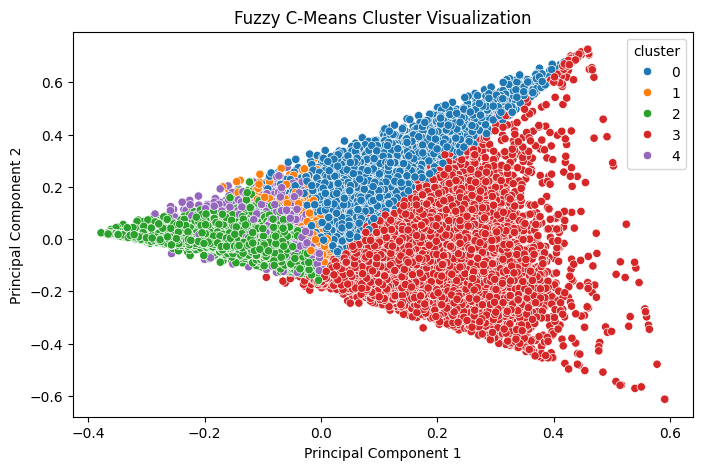

In [9]:
temp_df = df_pca.iloc[:, 0:2].copy()
temp_df.columns = ['pc1', 'pc2']
temp_df['cluster'] = cluster_labels

plt.figure(figsize=(8, 5))
sns.scatterplot(data=temp_df, x='pc1', y='pc2', hue='cluster', palette='tab10')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Fuzzy C-Means Cluster Visualization')
plt.show()

In [10]:
cross_df['cluster'] = cluster_labels

In [11]:
cluster1 = cross_df[cross_df.cluster == 0]
cluster2 = cross_df[cross_df.cluster == 1]
cluster3 = cross_df[cross_df.cluster == 2]
cluster4 = cross_df[cross_df.cluster == 3]
cluster5 = cross_df[cross_df.cluster == 4]

cluster1.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10)
cluster2.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10)
cluster3.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10)
cluster4.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10)
cluster5.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10)

aisle
fresh fruits                     15.020403
fresh vegetables                 10.570100
yogurt                           10.409661
packaged vegetables fruits        8.277491
water seltzer sparkling water     5.665397
packaged cheese                   5.553589
milk                              5.103286
chips pretzels                    4.390159
refrigerated                      3.665110
soy lactosefree                   3.518273
dtype: float64

    Cluster 1 consists of consumers with a strong preference for healthy and snack-oriented products,
    indicating a wellness-focused shopping behavior with minimal overlap across other categories.

    Cluster 2 represents shoppers who mainly purchase household essentials,
    with occasional purchases of convenience or frozen items, reflecting routine and functional buying behavior.

    Cluster 3 includes hybrid shoppers who show mixed preferences across multiple categories,
    particularly healthy snacks and household or pantry items, indicating flexible shopping patterns.

    Cluster 4 comprises consumers with a strong preference for pantry and frozen foods,
    suggesting planned, stock-up-oriented purchasing behavior.

    Cluster 5 captures balanced shoppers whose purchases are evenly distributed across categories,
    indicating diverse behavior that may correspond to new or infrequent Instacart users.